# Skin cancer detection by CorgiVision

<a href="https://githubtocolab.com/corgi-vision/skin-cancer-detection/blob/main/explore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Downloading the dataset

The kaggle challange can be [accessed  here](https://www.kaggle.com/competitions/isic-2024-challenge/overview). \
The dataset is a set of RGB images with varying dimentions. The images are labeled whether they depict skin cancer. Additional metadata is also provided (e.g. age, sex, etc. of the patient)


Run the cell below to download the files from Google Drive, where we are already uploaded it.

In [17]:
import zipfile
!pip install gdown
import gdown

def download_data():
    if(not Path("data").exists()):

    # extract zip to the data dir
        gdown.download("https://drive.google.com/uc?id=13z3O9BI082DFGs8aSaCAzWDbYCs_ZLxT", "resources.zip", quiet=False)
        with zipfile.ZipFile("resources.zip", 'r') as zip_ref:
            zip_ref.extractall("data")

In [18]:
download_data()

## Loading the data

Loading the images, corresponding metadata and obtaining the labels

In [19]:
DATASET_HOME = Path.cwd() /  "data"
TRAIN_IMAGES_PATH = DATASET_HOME / "train-image" / "image"
METADATA_PATH = DATASET_HOME / "train-metadata.csv"

image_iterator = TRAIN_IMAGES_PATH.glob("*")
image_count = len(list(image_iterator))
print("The dataset contains {} images".format(image_count))

The dataset contains 401059 images


In [20]:
# Read the metadata, which contains the labels
pd.set_option('display.max_columns', None)

df = pd.read_csv(METADATA_PATH)
df = df[
    [
        'isic_id',
        'target',
        'age_approx',
        'sex',
        'tbp_lv_areaMM2',
        'tbp_lv_area_perim_ratio',
        'tbp_lv_color_std_mean',
        'tbp_lv_deltaLBnorm',
        'tbp_lv_location',
        'tbp_lv_minorAxisMM',
        'tbp_lv_nevi_confidence',
        'tbp_lv_norm_border',
        'tbp_lv_norm_color',
        'tbp_lv_perimeterMM',
        'tbp_lv_radial_color_std_max',
        'tbp_lv_symm_2axis',
        'tbp_lv_symm_2axis_angle'
    ]
]

df.head()

<ipython-input-20-5538ff960f77>:4: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(METADATA_PATH)


,isic_id,target,age_approx,sex,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaLBnorm,tbp_lv_location,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle
0,ISIC_0015670,0,60.0,male,3.152561,27.476170,0.00000,5.784302,Right Leg - Upper,1.543016,2.628592e-03,7.091360,0.000000,9.307003,0.00000,0.590476,85
1,ISIC_0015845,0,60.0,male,0.919497,12.235290,0.00000,4.987244,Head & Neck,0.821918,1.334303e-07,2.116402,0.000000,3.354148,0.00000,0.285714,55
2,ISIC_0015864,0,60.0,male,3.265153,24.184620,0.00000,6.290359,Torso Back Top Third,1.194905,2.959177e-04,4.798335,0.000000,8.886309,0.00000,0.361905,105
3,ISIC_0015902,0,65.0,male,6.079940,14.889242,0.51452,6.400196,Torso Front Top Half,2.481328,2.198945e+01,1.975874,1.771705,9.514499,0.66469,0.209581,130
4,ISIC_0024200,0,55.0,male,2.101708,19.902560,0.00000,6.531302,Torso Front Top Half,0.929916,1.378832e-03,3.658854,0.000000,6.467562,0.00000,0.313433,20


In [21]:
df.drop(columns=["isic_id","target"]).describe()

,age_approx,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaLBnorm,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle
count,398261.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000
mean,58.012986,8.539975,19.084517,1.070408,7.538922,2.539773,38.520265,3.451523,3.091590,11.878891,1.016459,0.306823,86.332073
std,13.596165,9.679312,5.357863,0.762918,2.404951,1.173169,41.480936,1.724557,2.044813,5.919302,0.734631,0.125038,52.559511
min,5.000000,0.431601,10.761634,0.000000,3.001138,0.273973,0.000000,0.589426,0.000000,2.579237,0.000000,0.052034,0.000000
25%,50.000000,4.109589,15.426205,0.574909,5.748160,1.812707,0.109819,2.143836,1.728774,8.338364,0.563891,0.211429,40.000000
50%,60.000000,5.685870,17.423950,0.931402,6.946320,2.265201,14.408514,2.996933,2.764664,10.015440,0.902281,0.282297,90.000000
75%,70.000000,9.119910,21.011340,1.412154,8.748403,2.905918,87.791395,4.358399,4.120246,13.209100,1.334523,0.382022,130.000000
max,85.000000,334.152700,87.205340,9.952932,30.487456,18.387900,100.000000,10.000000,10.000000,102.493900,11.491140,0.977055,175.000000


In [22]:
import pandas as pd
from PIL import Image
from pathlib import Path
from itertools import islice

# Set up how much of the dataset the actual data we would like to use for training
load_size = .001
load_count = int(df.shape[0] * load_size)
print("Number of images to be loaded: {}".format(load_count))

metadata = df.iloc[:load_count]  # slice the rows
bad_index_list=[]
# Initialize a list for images
X = []

# Load images using the metadata
for index, row in metadata.iterrows():
    filename = row['isic_id']
    file_path = TRAIN_IMAGES_PATH / f"{filename}.jpg"

    # Check if the file exists
    if file_path.exists():
        with Image.open(file_path) as im:
            X.append(Image.open(file_path))
    else:
        bad_index_list.append(index)
        print(f"File {file_path} does not exist.")

#Drop the metadatata where is no image connected
metadata.drop(bad_index_list)

print("Loaded metadata shape:", metadata.shape)
print("Number of images loaded:", len(X))

Y = metadata["target"].tolist()
print(Y)

metadata["target"].map({0: "Benign", 1: "Malignant"}).value_counts()



Number of images to be loaded: 401
Loaded metadata shape: (401, 17)
Number of images loaded: 401
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

,count
target,
Benign,400
Malignant,1


### Show example of a negative and a positive sample

Text(0.5, 1.0, 'Benign')

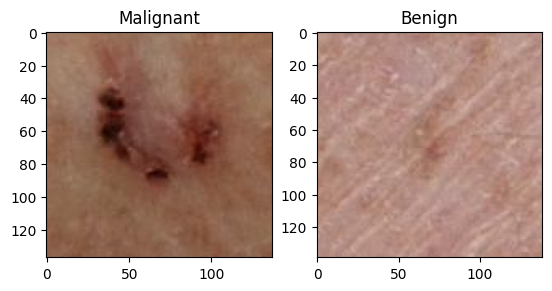

In [23]:
malignant_idx = next(i for i,v in enumerate(Y) if v == 1)
malignant = X[malignant_idx]
benign_idx = next(i for i,v in enumerate(Y) if v == 0)
benign = X[benign_idx]

fig, ax = plt.subplots(1, 2)
ax[0].imshow(malignant)
ax[0].set_title("Malignant")

ax[1].imshow(benign)
ax[1].set_title("Benign")

## Preprocessing

* Scaling the images and metadata
* Creating the train-test splits

#### Image preprocessing
Not all images are of the same dimentionality. The most straight-forward solution is to rescale the images to match the most frequent dimentions. \
This solution shouldn't significantly worsen the performance of the models as long as all the images are n by n sized

In [24]:
sizes = [im.size for im in X]
not_square = list(filter(lambda s: s[0] != s[1] ,sizes))
print(f"{len(not_square)} images are not n by n.")

values, counts = np.unique(sizes, return_counts=True)
most_frequent = values[np.argmax(counts)]
print(f"Most frequent size: {most_frequent}")

0 images are not n by n.
Most frequent size: 139


In [25]:
scaled_images = [im.resize([most_frequent, most_frequent]) for im in X]

for im in X:
    im.close() # Against memory leaks

# Maping to a np array and scaling the images to the [0,1] interval
X_scaled = np.array(scaled_images) / 255
X_scaled.shape

(401, 139, 139, 3)

#### Metadata preprocessing

To preprocess metadata, apply appropriate scalers, convert binary fields to numeric format, and one-hot encode fields with multiple categorical options. Then, combine all preprocessed data and convert it to a compatible NumPy array for modeling.

In [26]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Create instances of scalers
z_score_scaler = StandardScaler()

# Scale numerical features using StandardScaler
# Handle missing values by dropping them or filling them
meta_z_scaled = pd.DataFrame(
    z_score_scaler.fit_transform(metadata[[
        'age_approx',
        'tbp_lv_areaMM2',
        'tbp_lv_area_perim_ratio',
        'tbp_lv_color_std_mean',
        'tbp_lv_deltaLBnorm',
        'tbp_lv_minorAxisMM',
        'tbp_lv_nevi_confidence',
        'tbp_lv_norm_border',
        'tbp_lv_norm_color',
        'tbp_lv_perimeterMM',
        'tbp_lv_radial_color_std_max',
        'tbp_lv_symm_2axis',
        'tbp_lv_symm_2axis_angle'
    ]]),
    columns=[
        'age_approx',
        'tbp_lv_areaMM2',
        'tbp_lv_area_perim_ratio',
        'tbp_lv_color_std_mean',
        'tbp_lv_deltaLBnorm',
        'tbp_lv_minorAxisMM',
        'tbp_lv_nevi_confidence',
        'tbp_lv_norm_border',
        'tbp_lv_norm_color',
        'tbp_lv_perimeterMM',
        'tbp_lv_radial_color_std_max',
        'tbp_lv_symm_2axis',
        'tbp_lv_symm_2axis_angle'
    ]
)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # sparse=False returns a numpy array

# Encode categorical data into one-hot vectors
encoded_data = encoder.fit_transform(metadata[['sex', 'tbp_lv_location']])

# Create a DataFrame from the encoded data
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['sex', 'tbp_lv_location']))

# Concatenate scaled features and dummy variables
meta_scaled = pd.concat([meta_z_scaled, encoded_df], axis=1)

# Output the shape of the resulting DataFrame
print("Final shape of concatenated DataFrame:", meta_scaled.shape)


Final shape of concatenated DataFrame: (401, 34)


#### Train - Test split

In [27]:
from sklearn.model_selection import train_test_split

test_size=0.3

# Validation split to be handled by the model
# No need to specify validation split here, we will be able to do it inside the learning model
X_train, X_test, meta_train, meta_test, Y_train, Y_test = train_test_split(X_scaled, meta_scaled[:401], Y, test_size=test_size,shuffle=True, random_state=42)
print(f"Training dataset: {X_train.shape[0]}\nTest dataset: {X_test.shape[0]}")

Training dataset: 280
Test dataset: 121


Metadata:
age_approx: 0.12
tbp_lv_areaMM2: -0.07
tbp_lv_area_perim_ratio: 1.77
tbp_lv_color_std_mean: -0.13
tbp_lv_deltaLBnorm: -0.66
tbp_lv_minorAxisMM: -0.06
tbp_lv_nevi_confidence: -0.84
tbp_lv_norm_border: 1.36
tbp_lv_norm_color: 0.09
tbp_lv_perimeterMM: 0.51
tbp_lv_radial_color_std_max: 0.27
tbp_lv_symm_2axis: 0.70
tbp_lv_symm_2axis_angle: 1.47
sex_female: 0.00
sex_male: 1.00
sex_nan: 0.00
tbp_lv_location_Head & Neck: 0.00
tbp_lv_location_Left Arm: 0.00
tbp_lv_location_Left Arm - Lower: 0.00
tbp_lv_location_Left Arm - Upper: 0.00
tbp_lv_location_Left Leg: 0.00
tbp_lv_location_Left Leg - Lower: 1.00
tbp_lv_location_Left Leg - Upper: 0.00
tbp_lv_location_Right Arm - Lower: 0.00
tbp_lv_location_Right Arm - Upper: 0.00
tbp_lv_location_Right Leg: 0.00
tbp_lv_location_Right Leg - Lower: 0.00
tbp_lv_location_Right Leg - Upper: 0.00
tbp_lv_location_Torso Back Bottom Third: 0.00
tbp_lv_location_Torso Back Middle Third: 0.00
tbp_lv_location_Torso Back Top Third: 0.00
tbp_lv_location_Torso F

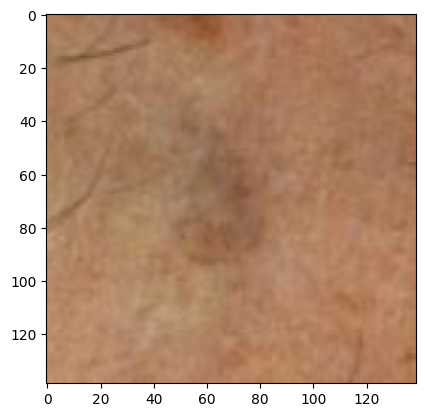

In [35]:
# Inspect a random training instance
random_idx = np.random.randint(0, X_train.shape[0])
plt.imshow(X_train[random_idx])

# Get metadata as a NumPy array
metadata_array = meta_train.iloc[random_idx].values

# Format metadata for display
metadata_string = ""
for i, col in enumerate(meta_train.columns):
        metadata_string += f"{col}: {metadata_array[i]:.2f}\n" if isinstance(metadata_array[i], float) else f"{col}: {metadata_array[i]}\n"

# Print the formatted metadata string
print(f"Metadata:\n{metadata_string}")
print("Malignant" if Y[random_idx] else "Benign")